# 环境准备

In [42]:
%%time
import jieba
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

Wall time: 0 ns


# 加载数据

In [43]:
%%time
names = ['sentence1', 'sentence2', 'label']
train = pd.read_csv("../xfdata/train.csv", header=None, sep="\t", names=names)
test = pd.read_csv("../xfdata/test.csv", header=None, sep="\t", names=names)

Wall time: 132 ms


# 特征工程

## 中文分词

In [44]:
%%time
def text_cut_words(short_dialogue_text, mapdict=None)->list:
    cut_words = list(jieba.cut(short_dialogue_text, cut_all=False))
    if mapdict != None:
        words = [word if word not in mapdict else mapdict[word] for word in cut_words]
    else:
        words = cut_words
    return words

train["sentence1_words"] = train["sentence1"].apply(text_cut_words)
train["sentence2_words"] = train["sentence2"].apply(text_cut_words)
test["sentence1_words"] = test["sentence1"].apply(text_cut_words)
test["sentence2_words"] = test["sentence2"].apply(text_cut_words)

Wall time: 5.44 s


## 词向量化

In [45]:
%%time
# 创建一个Tokenizer对象
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit_on_texts函数可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
tokenizer.fit_on_texts(train['sentence1_words'].tolist() + train['sentence2_words'].tolist())
# 得到每个词的编号
vocab=tokenizer.word_index

# 将每个样本中的每个词转换为数字列表，使用每个词的编号进行编号
x_train_word1_ids = tokenizer.texts_to_sequences(train['sentence1_words'])
x_train_word2_ids = tokenizer.texts_to_sequences(train['sentence2_words'])
x_test_word1_ids = tokenizer.texts_to_sequences(test['sentence1_words'])
x_test_word2_ids = tokenizer.texts_to_sequences(test['sentence2_words'])

# 合并列表
x_train_word_ids = []
for i,j in zip(x_train_word1_ids, x_train_word2_ids):
    x_train_word_ids.append(i + j)
x_test_word_ids = []
for i,j in zip(x_test_word1_ids, x_test_word2_ids):
    x_test_word_ids.append(i + j)
    
# 生成序列：每条样本长度不唯一，将每条样本的长度设置一个固定值。将超过固定值的部分截掉，不足的在最前面用0填充
x_train_padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(x_train_word_ids, maxlen=50)
x_test_padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(x_test_word_ids, maxlen=50)

Wall time: 906 ms


# LeNet-5模型

## 构造网络

In [54]:
%%time
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(vocab) + 1, 300, input_length=50)) #使用Embeeding层将每个词编码转换为词向量
model.add(tf.keras.layers.Conv1D(256, 5, padding='same'))
model.add(tf.keras.layers.MaxPooling1D(3, 3, padding='same'))
model.add(tf.keras.layers.Conv1D(128, 5, padding='same'))
model.add(tf.keras.layers.MaxPooling1D(3, 3, padding='same'))
model.add(tf.keras.layers.Conv1D(64, 3, padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())  # (批)规范化层
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

Wall time: 109 ms


## 查看结构

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           7106700   
                                                                 
 conv1d_9 (Conv1D)           (None, 50, 256)           384256    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 17, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 17, 128)           163968    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 6, 64)            

## 模型编译

In [56]:
%%time
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Wall time: 3.99 ms


## 模型训练

In [58]:
%%time
one_hot_labels = tf.keras.utils.to_categorical(train['label'], num_classes=2)  # 将标签转换为one-hot编码
history = model.fit(x_train_padded_seqs, one_hot_labels, epochs=5, batch_size=800, validation_split=0.3)

Epoch 1/5
44/44 [==============================] - 30s 690ms/step - loss: 0.1322 - accuracy: 0.9510 - val_loss: 0.6104 - val_accuracy: 0.7201
Epoch 2/5
44/44 [==============================] - 30s 688ms/step - loss: 0.0545 - accuracy: 0.9828 - val_loss: 0.5643 - val_accuracy: 0.7246
Epoch 3/5
44/44 [==============================] - 30s 687ms/step - loss: 0.0281 - accuracy: 0.9925 - val_loss: 0.5592 - val_accuracy: 0.7183
Epoch 4/5
44/44 [==============================] - 30s 689ms/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.5609 - val_accuracy: 0.7183
Epoch 5/5
44/44 [==============================] - 32s 732ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.5834 - val_accuracy: 0.7218
Wall time: 2min 32s


## 模型预测

In [ ]:
%%time
y_pred = model.predict(x_test_padded_seqs)  # 预测的是类别，结果就是类别号
y_pred = np.argmax(y_pred, axis=1)
pd.Series(y_pred).to_csv("../prediction-result/submit.csv", index=False, header=None)

410/625 [==================>...........] - ETA: 1s

# 输出模型结构

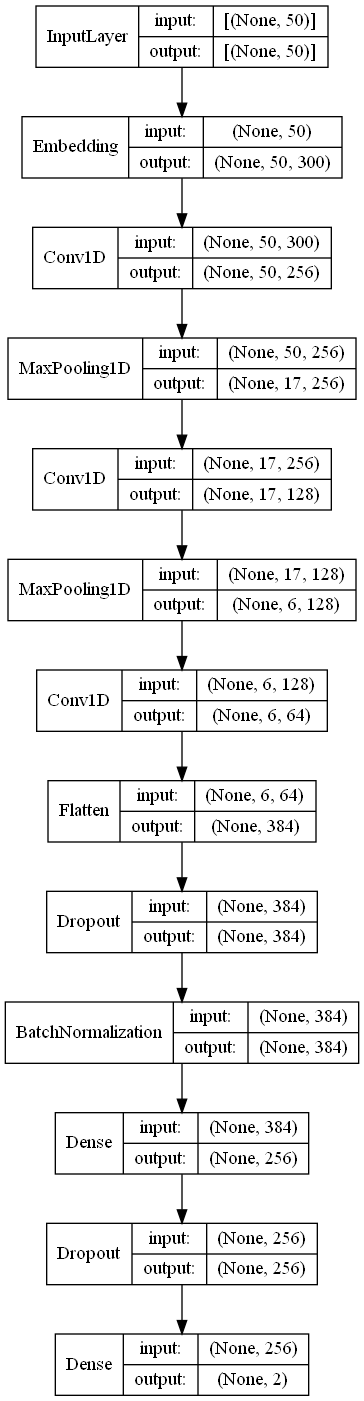

In [63]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='../prediction-result/model.png', show_shapes=True, show_layer_names=False)